# Transfer learning with PyTorch

In this example we'll implement fine-tuning and feature extracting transfer learning using the CIFAR-10 dataset.

_This example is partially based on_ [https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py](https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py).<br/>
_The licensing information and the author of the base version are:<br/>
License: BSD<br/>
Author: Sasank Chilamkurthy_

In [2]:
!pip install torch
!pip install torchvision

Load the training data (`train_loader`):

In [3]:
import torch

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

batch_size = 50

train_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

train_set = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=train_data_transform)

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 25398632.29it/s]


Extracting data/cifar-10-python.tar.gz to data


Load the training data (train_loader):

In [4]:
val_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

val_set = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=val_data_transform)

val_order = DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified


Select device:

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Define `train_model` and `test_model` helper functions:

In [6]:
def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))


def test_model(model, loss_function, data_loader):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)

    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

    return total_loss, total_acc

Define 2 functions that build transfer learning models for either feature extacting, or fine-tuning. Both models use the `torchvision.models.resnet18` ImageNet pretrained model. We'll start with feature extracting, which "locks" all model parameters (weights) except for the final fully-connected layer:


In [7]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import MobileNet_V3_Small_Weights, mobilenet_v3_small


def tl_feature_extractor(epochs=5):
    # load the pre-trained model
    model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # exclude existing parameters from backward pass
    # for performance
    for param in model.parameters():
        param.requires_grad = False

    # newly constructed layers have requires_grad=True by default
    num_features = model.classifier[0].in_features
    model.classifier = nn.Linear(num_features, 10)

    # transfer to GPU (if available)
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()

    # only parameters of the final layer are being optimized
    optimizer = optim.Adam(model.classifier.parameters())

    # train
    test_acc = list()  # collect accuracy for plotting
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc.cpu())

    plot_accuracy(test_acc)


def tl_fine_tuning(epochs=5):
    # load the pre-trained model
    model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)

    # replace the last layer
    num_features = model.classifier[0].in_features
    model.classifier = nn.Linear(num_features, 10)

    # transfer the model to the GPU
    model = model.to(device)

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # We'll optimize all parameters
    optimizer = optim.Adam(model.parameters())

    # train
    test_acc = list()  # collect accuracy for plotting
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))

        train_model(model, loss_function, optimizer, train_loader)
        _, acc = test_model(model, loss_function, val_order)
        test_acc.append(acc.cpu())

    plot_accuracy(test_acc)

Define the `plot_accuracy` function:

In [8]:
import matplotlib.pyplot as plt


def plot_accuracy(accuracy: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy)
    plt.xticks(
        [i for i in range(0, len(accuracy))],
        [i + 1 for i in range(0, len(accuracy))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

Run the feature extractor model first:

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 234MB/s]


Epoch 1/5
Train Loss: 0.9994; Accuracy: 0.6779
Test Loss: 0.6688; Accuracy: 0.7722
Epoch 2/5
Train Loss: 0.7670; Accuracy: 0.7354
Test Loss: 0.6079; Accuracy: 0.7890
Epoch 3/5
Train Loss: 0.7204; Accuracy: 0.7481
Test Loss: 0.5851; Accuracy: 0.7974
Epoch 4/5
Train Loss: 0.6894; Accuracy: 0.7619
Test Loss: 0.5640; Accuracy: 0.8041
Epoch 5/5
Train Loss: 0.6793; Accuracy: 0.7630
Test Loss: 0.5593; Accuracy: 0.8039


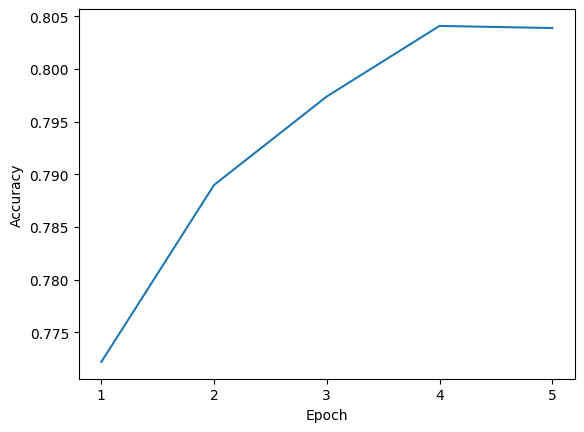

In [9]:
tl_feature_extractor()

Run the fine-tuning model next:

Epoch 1/5
Train Loss: 0.5283; Accuracy: 0.8152
Test Loss: 0.4450; Accuracy: 0.8507
Epoch 2/5
Train Loss: 0.3154; Accuracy: 0.8896
Test Loss: 0.3933; Accuracy: 0.8664
Epoch 3/5
Train Loss: 0.2518; Accuracy: 0.9123
Test Loss: 0.3797; Accuracy: 0.8687
Epoch 4/5
Train Loss: 0.2169; Accuracy: 0.9242
Test Loss: 0.3302; Accuracy: 0.8886
Epoch 5/5
Train Loss: 0.1816; Accuracy: 0.9352
Test Loss: 0.3441; Accuracy: 0.8866


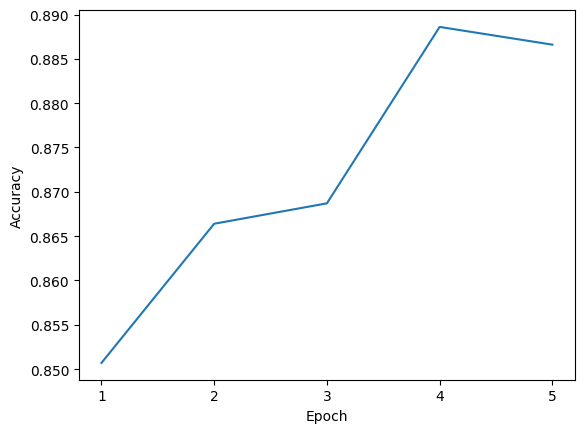

In [10]:
tl_fine_tuning()